# Part 1 A different pretrained model

The question: You will use a different pertained model (other than Inception V3), and produce the entire set of results. You will submit the complete notebook, with a paragraph in the end summarizing your results.

In this part, I'll use VGG16 instead of Inception V3 model as the pretrained model and remain other settings the same.

### 1. Load data & import required packages

In [3]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [2]:
!mkdir -p "/content/drive/My Drive/keras"
!mkdir -p "/content/drive/My Drive/keras/models"

In [1]:

# Uninstall TensorFlow 2.12.0
!pip uninstall tensorflow -y

# Install TensorFlow 2.17.0 2.15.1
!pip install tensorflow==2.17.0

# Reinstall any other required packages
!pip install 'keras<3.0.0' mediapipe-model-maker
!pip install tensorflow_addons


Found existing installation: tensorflow 2.15.1
Uninstalling tensorflow-2.15.1:
  Successfully uninstalled tensorflow-2.15.1
  Using cached tensorflow-2.17.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (4.2 kB)
Using cached tensorflow-2.17.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (601.3 MB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 666.3 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 106.5 MB/s eta 0:00:00
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.15.2
    Uninstalling tensorboard-2.15.2:
      Successfully uninstalled tensorboard-2.15.2
  Attempting uninstall: keras
    Found existing installation: keras 2.15.0
    Uninstalling keras-2.15.0:
      Successfully uninstalled keras-2.15.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
mediapip

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt # showing and rendering figures
# io related
from skimage.io import imread
import os
from glob import glob
# not needed in Kaggle, but required in Jupyter
%matplotlib inline

# Import TensorFlow 2.x
import tensorflow as tf
from tensorflow.keras import backend as K

from keras.applications.inception_v3 import preprocess_input
import numpy as np

from keras.applications.vgg16 import VGG16 as PTModel
#from keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten, Input, Conv2D, multiply, LocallyConnected2D, Lambda
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten, Input, Conv2D, multiply,LocallyConnected2D, Lambda

from keras.models import Model
from keras.layers import BatchNormalization
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import accuracy_score, classification_report

In [5]:
!ls /content/drive/My\ Drive/Colab\ Notebooks/


'Another copy of 23_tutorial.vision.ipynb'
'Another copy of neural_style_tutorial.ipynb'
'Copy of 23_tutorial (1).vision.ipynb'
'Copy of 23_tutorial.vision.ipynb'
'Copy of hw4.ipynb'
'Copy of HW6 example notebook.ipynb'
'Copy of quick_start.ipynb'
'HW2_Classifying retina images with transfer learning.ipynb'
 HW3b.ipynb
 HW4
 hw5_Part1.ipynb
'Li-Ting Ku-Copy of Tutorial of Neural Style Transfer (1).ipynb'
'Li-Ting Ku-Copy of Tutorial of Neural Style Transfer.ipynb'
'Li-Ting Ku Why GPU.ipynb'
 project
 Project.ipynb
 train
 train1


In [4]:
retina_df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/train/trainLabels.csv')

In [5]:
%cd /content/drive/My Drive/Colab Notebooks/train/

retina_df['PatientId'] = retina_df['image'].map(lambda x: x.split('_')[0])
retina_df['path'] = retina_df['image'].map(lambda x:'{}.jpeg'.format(x))
retina_df['exists'] = retina_df['path'].map(os.path.exists)
print(retina_df['exists'].sum(), 'images found of', retina_df.shape[0], 'total')

/content/drive/.shortcut-targets-by-id/1fq90qAXI4roRaWKdELFSu7nZLVKnT6Z5/train
19387 images found of 35126 total


In [6]:
from keras.utils import to_categorical

retina_df['eye'] = retina_df['image'].map(lambda x: 1 if x.split('_')[-1]=='left' else 0)
retina_df['level_cat'] = retina_df['level'].map(lambda x: to_categorical(x, 1+retina_df['level'].max()))

retina_df.dropna(inplace = True)
retina_df = retina_df[retina_df['exists']]
retina_df.sample(3)

,image,level,PatientId,path,exists,eye,level_cat
9030,11319_left,0,11319,11319_left.jpeg,True,1,"[1.0, 0.0, 0.0, 0.0, 0.0]"
19484,24608_left,0,24608,24608_left.jpeg,True,1,"[1.0, 0.0, 0.0, 0.0, 0.0]"
11694,14681_left,0,14681,14681_left.jpeg,True,1,"[1.0, 0.0, 0.0, 0.0, 0.0]"


### 2. About the data
Examine the distribution of eye and severity, split data into training and validation, and balance the distribution in the training set.

array([[<Axes: title={'center': 'level'}>,
        <Axes: title={'center': 'eye'}>]], dtype=object)

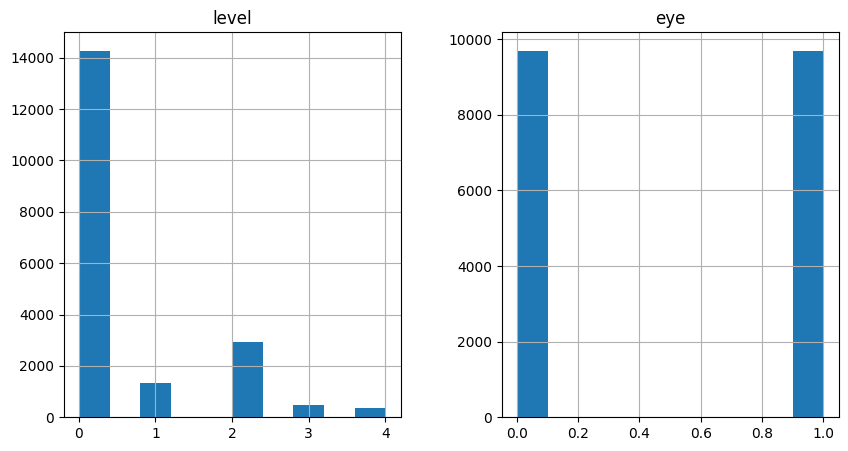

In [6]:
retina_df[['level', 'eye']].hist(figsize = (10, 5))


In [7]:
import os

# Function to check if the file size is non-zero
def is_non_zero_file(file_path):
    return os.path.getsize(file_path) > 0

# Apply this check to your DataFrame
retina_df['non_zero_size'] = retina_df['path'].apply(is_non_zero_file)

# Filter out files with zero size
non_zero_retina_df = retina_df[retina_df['non_zero_size']]

# Now you can proceed with valid files only
print(f"Files with non-zero size: {non_zero_retina_df.shape[0]} out of {retina_df.shape[0]} total files.")


Files with non-zero size: 19386 out of 19387 total files.


In [8]:
from sklearn.model_selection import train_test_split
rr_df = non_zero_retina_df[['PatientId', 'level']].drop_duplicates()
train_ids, valid_ids = train_test_split(rr_df['PatientId'],
                                   test_size = 0.25,
                                   random_state = 2018,
                                   stratify = rr_df['level'])
raw_train_df = non_zero_retina_df[non_zero_retina_df['PatientId'].isin(train_ids)]
valid_df = non_zero_retina_df[non_zero_retina_df['PatientId'].isin(valid_ids)]
print('train', raw_train_df.shape[0], 'validation', valid_df.shape[0])

train 14956 validation 5276


New Data Size: 750 Old Size: 14956


<ipython-input-9-6140838df9bb>:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  train_df = raw_train_df.groupby(['level', 'eye']).apply(lambda x: x.sample(75, replace = True)


array([[<Axes: title={'center': 'level'}>,
        <Axes: title={'center': 'eye'}>]], dtype=object)

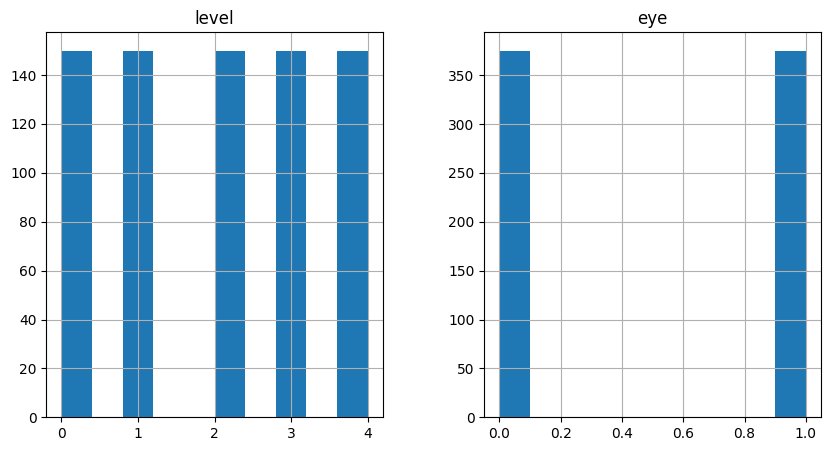

In [9]:
train_df = raw_train_df.groupby(['level', 'eye']).apply(lambda x: x.sample(75, replace = True)
                                                      ).reset_index(drop = True)
print('New Data Size:', train_df.shape[0], 'Old Size:', raw_train_df.shape[0])
train_df[['level', 'eye']].hist(figsize = (10, 5))

In [10]:
from keras.applications.inception_v3 import preprocess_input
import numpy as np
import tensorflow_addons
from tensorflow_addons.image.transform_ops import angles_to_projective_transforms
from tensorflow_addons.image import transform as T
from tensorflow_addons.image import compose_transforms

IMG_SIZE = (512, 512) # slightly smaller than vgg16 normally expects
def tf_image_loader(out_size,
                      horizontal_flip = True,
                      vertical_flip = False,
                     random_brightness = True,
                     random_contrast = True,
                    random_saturation = True,
                    random_hue = True,
                      color_mode = 'rgb',
                       preproc_func = preprocess_input,
                       on_batch = False):
    def _func(X):
        with tf.name_scope('image_augmentation'):
            with tf.name_scope('input'):
                X = tf.image.decode_png(tf.io.read_file(X), channels = 3 if color_mode == 'rgb' else 0)
                X = tf.image.resize(X, out_size)
            with tf.name_scope('augmentation'):
                if horizontal_flip:
                    X = tf.image.random_flip_left_right(X)
                if vertical_flip:
                    X = tf.image.random_flip_up_down(X)
                if random_brightness:
                    X = tf.image.random_brightness(X, max_delta = 0.1)
                if random_saturation:
                    X = tf.image.random_saturation(X, lower = 0.75, upper = 1.5)
                if random_hue:
                    X = tf.image.random_hue(X, max_delta = 0.15)
                if random_contrast:
                    X = tf.image.random_contrast(X, lower = 0.75, upper = 1.5)
                return preproc_func(X)
    if on_batch:
        # we are meant to use it on a batch
        def _batch_func(X, y):
            return tf.map_fn(_func, X), y
        return _batch_func
    else:
        # we apply it to everything
        def _all_func(X, y):
            return _func(X), y
        return _all_func

def tf_augmentor(out_size,
                intermediate_size = (640, 640),
                 intermediate_trans = 'crop',
                 batch_size = 16,
                   horizontal_flip = True,
                  vertical_flip = False,
                 random_brightness = True,
                 random_contrast = True,
                 random_saturation = True,
                    random_hue = True,
                  color_mode = 'rgb',
                   preproc_func = preprocess_input,
                   min_crop_percent = 0.001,
                   max_crop_percent = 0.005,
                   crop_probability = 0.5,
                   rotation_range = 10):

    load_ops = tf_image_loader(out_size = intermediate_size,
                               horizontal_flip=horizontal_flip,
                               vertical_flip=vertical_flip,
                               random_brightness = random_brightness,
                               random_contrast = random_contrast,
                               random_saturation = random_saturation,
                               random_hue = random_hue,
                               color_mode = color_mode,
                               preproc_func = preproc_func,
                               on_batch=False)
    def batch_ops(X, y):
        batch_size = tf.shape(X)[0]
        with tf.name_scope('transformation'):
            # code borrowed from https://becominghuman.ai/data-augmentation-on-gpu-in-tensorflow-13d14ecf2b19
            # The list of affine transformations that our image will go under.
            # Every element is Nx8 tensor, where N is a batch size.
            transforms = []
            identity = tf.constant([1, 0, 0, 0, 1, 0, 0, 0], dtype=tf.float32)
            if rotation_range > 0:
                angle_rad = rotation_range / 180 * np.pi
                angles = tf.random.uniform([batch_size], -angle_rad, angle_rad)
                transforms += [angles_to_projective_transforms(angles, intermediate_size[0], intermediate_size[1])]
                #rotated_X = tf.image.rot90(X, tf.cast(tf.random.uniform([], minval=0, maxval=4, dtype=tf.int32), tf.int32))
                #transforms.append(rotated_X)

            if crop_probability > 0:
                crop_pct = tf.random.uniform([batch_size], min_crop_percent, max_crop_percent)
                left = tf.random.uniform([batch_size], 0, intermediate_size[0] * (1.0 - crop_pct))
                top = tf.random.uniform([batch_size], 0, intermediate_size[1] * (1.0 - crop_pct))
                crop_transform = tf.stack([
                      crop_pct,
                      tf.zeros([batch_size]), top,
                      tf.zeros([batch_size]), crop_pct, left,
                      tf.zeros([batch_size]),
                      tf.zeros([batch_size])
                  ], 1)
                coin = tf.less(tf.random_uniform([batch_size], 0, 1.0), crop_probability)
                transforms += [tf.where(coin, crop_transform, tf.tile(tf.expand_dims(identity, 0), [batch_size, 1]))]
            if len(transforms)>0:
                X = tensorflow_addons.image.transform(X, tensorflow_addons.image.compose_transforms(transforms), interpolation='BILINEAR') # or 'NEAREST'
                #X = tfa.image.transform(X, tfa.image.compose_transforms(transforms), interpolation='BILINEAR')

            if intermediate_trans=='scale':
                X = tf.image.resize(X, out_size)
            elif intermediate_trans=='crop':
                X = tf.image.resize_with_crop_or_pad(X, out_size[0], out_size[1])
            else:
                raise ValueError('Invalid Operation {}'.format(intermediate_trans))
            return X, y
    def _create_pipeline(in_ds):
        batch_ds = in_ds.map(load_ops, num_parallel_calls=4).batch(batch_size)
        return batch_ds.map(batch_ops)
    return _create_pipeline

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [11]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
#from tensorflow.keras import backend as K
from tensorflow.compat.v1.keras import backend as K
def flow_from_dataframe(idg,
                        in_df,
                        path_col,
                        y_col,
                        shuffle = True,
                        color_mode = 'rgb'):
    files_ds = tf.data.Dataset.from_tensor_slices((in_df[path_col].values,
                                                   np.stack(in_df[y_col].values,0)))
    in_len = in_df[path_col].values.shape[0]
    while True:
        if shuffle:
            files_ds = files_ds.shuffle(in_len) # shuffle the whole dataset

        next_batch = idg(files_ds).repeat().make_one_shot_iterator().get_next()
        for i in range(max(in_len//32,1)):
            # NOTE: if we loop here it is 'thread-safe-ish' if we loop on the outside it is completely unsafe
            yield K.get_session().run(next_batch)



Instructions for updating:
non-resource variables are not supported in the long term


In [12]:
batch_size = 10
core_idg = tf_augmentor(out_size = IMG_SIZE,
                        color_mode = 'rgb',
                        vertical_flip = True,
                        crop_probability=0.0, # crop doesn't work yet
                        batch_size = batch_size)
valid_idg = tf_augmentor(out_size = IMG_SIZE, color_mode = 'rgb',
                         crop_probability=0.0,
                         horizontal_flip = False,
                         vertical_flip = False,
                         random_brightness = False,
                         random_contrast = False,
                         random_saturation = False,
                         random_hue = False,
                         rotation_range = 0,
                        batch_size = batch_size)

train_gen = flow_from_dataframe(core_idg, train_df,
                             path_col = 'path',
                            y_col = 'level_cat')

valid_gen = flow_from_dataframe(valid_idg, valid_df,
                             path_col = 'path',
                            y_col = 'level_cat') # we can use much larger batches for evaluation

### 3. Validation Set and training set

Instructions for updating:
This is a deprecated API that should only be used in TF 1 graph mode and legacy TF 2 graph mode available through `tf.compat.v1`. In all other situations -- namely, eager mode and inside `tf.function` -- you can consume dataset elements using `for elem in dataset: ...` or by explicitly creating iterator via `iterator = iter(dataset)` and fetching its elements via `values = next(iterator)`. Furthermore, this API is not available in TF 2. During the transition from TF 1 to TF 2 you can use `tf.compat.v1.data.make_one_shot_iterator(dataset)` to create a TF 1 graph mode style iterator for a dataset created through TF 2 APIs. Note that this should be a transient state of your code base as there are in general no guarantees about the interoperability of TF 1 and TF 2 code.


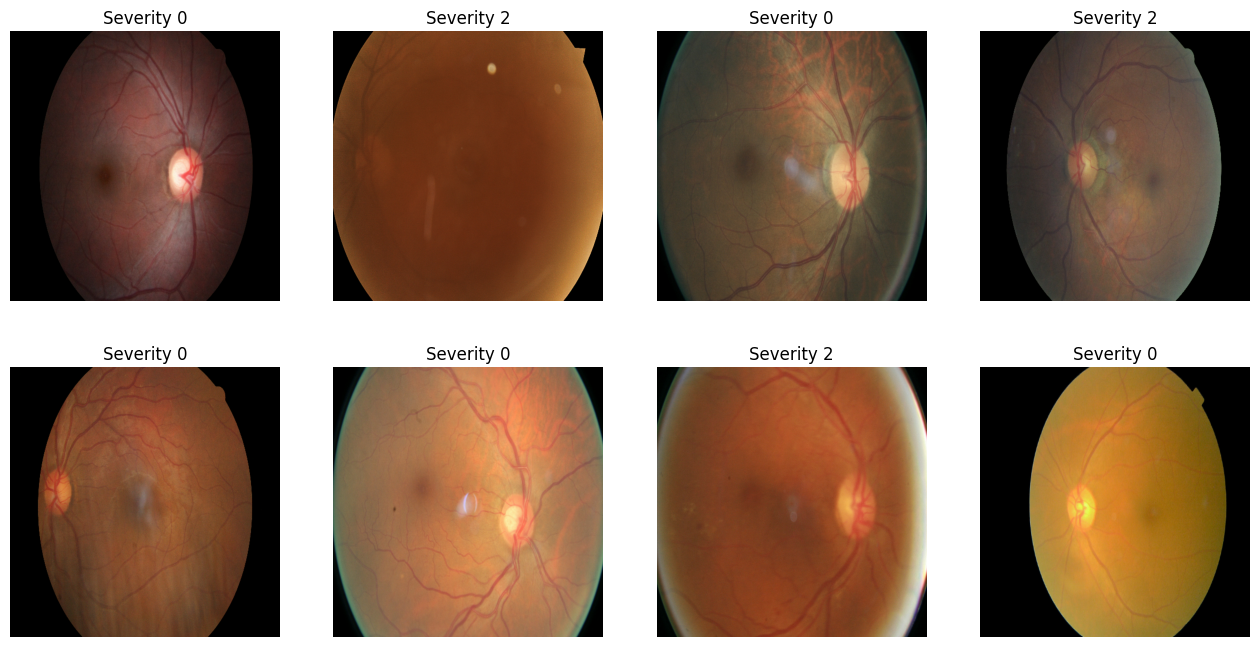

In [13]:
t_x, t_y = next(valid_gen)
fig, m_axs = plt.subplots(2, 4, figsize = (16, 8))
for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
    c_ax.imshow(np.clip(c_x*127+127, 0, 255).astype(np.uint8))
    c_ax.set_title('Severity {}'.format(np.argmax(c_y, -1)))
    c_ax.axis('off')

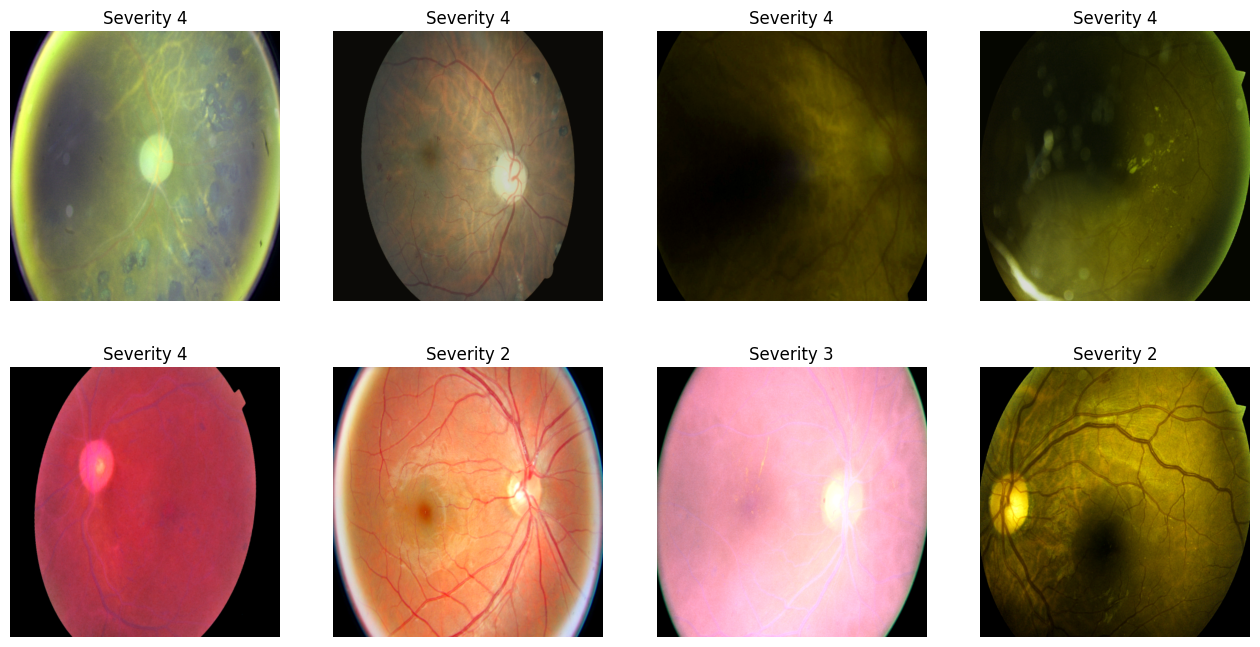

In [14]:
t_x, t_y = next(train_gen)
fig, m_axs = plt.subplots(2, 4, figsize = (16, 8))
for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
    c_ax.imshow(np.clip(c_x*127+127, 0, 255).astype(np.uint8))
    c_ax.set_title('Severity {}'.format(np.argmax(c_y, -1)))
    c_ax.axis('off')

### 4. The attention model

In [32]:
in_lay = Input(t_x.shape[1:])
base_pretrained_model = PTModel(input_shape =  t_x.shape[1:], include_top = False, weights = 'imagenet')
base_pretrained_model.trainable = False
pt_depth = base_pretrained_model.layers[-1].output_shape
pt_features = base_pretrained_model(in_lay)
bn_features = BatchNormalization()(pt_features)

# here we do an attention mechanism to turn pixels in the GAP on an off

attn_layer = Conv2D(64, kernel_size = (1,1), padding = 'same', activation = 'relu')(Dropout(0.5)(bn_features))
attn_layer = Conv2D(16, kernel_size = (1,1), padding = 'same', activation = 'relu')(attn_layer)
attn_layer = Conv2D(8, kernel_size = (1,1), padding = 'same', activation = 'relu')(attn_layer)
attn_layer = Conv2D(1,
                    kernel_size = (1,1),
                    padding = 'valid',
                    activation = 'sigmoid')(attn_layer)
# fan it out to all of the channels
up_c2_w = np.ones((1, 1, 1, pt_depth[-1]))
up_c2 = Conv2D(pt_depth[-1], kernel_size = (1,1), padding = 'same',
               activation = 'linear', use_bias = False, weights = [up_c2_w])
up_c2.trainable = False
attn_layer = up_c2(attn_layer)

mask_features = multiply([attn_layer, bn_features])
gap_features = GlobalAveragePooling2D()(mask_features)
gap_mask = GlobalAveragePooling2D()(attn_layer)
# to account for missing values from the attention model
gap = Lambda(lambda x: x[0]/x[1], name = 'RescaleGAP')([gap_features, gap_mask])
gap_dr = Dropout(0.25)(gap)
dr_steps = Dropout(0.25)(Dense(128, activation = 'relu')(gap_dr))
out_layer = Dense(t_y.shape[-1], activation = 'softmax')(dr_steps)
retina_model = Model(inputs = [in_lay], outputs = [out_layer])
from keras.metrics import top_k_categorical_accuracy
def top_2_accuracy(in_gt, in_pred):
    return top_k_categorical_accuracy(in_gt, in_pred, k=2)

retina_model.compile(optimizer = 'adam', loss = 'categorical_crossentropy',
                           metrics = ['categorical_accuracy', top_2_accuracy])
retina_model.summary()

Instructions for updating:
Colocations handled automatically by placer.


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 512, 512, 3)]        0         []                            
                                                                                                  
 vgg16 (Functional)          (None, 16, 16, 512)          1471468   ['input_3[0][0]']             
                                                          8                                       
                                                                                                  
 batch_normalization (Batch  (None, 16, 16, 512)          2048      ['vgg16[0][0]']               
 Normalization)                                                                                   
                                                                                            

In [18]:
weight_path="/content/drive/My Drive/keras/model/{}_weights.best.hdf5".format('retina')

checkpoint = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1,
                             save_best_only=True, mode='min', save_weights_only = True)

reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss', factor=0.8, patience=3, verbose=1, mode='auto', min_delta=0.0001, cooldown=5, min_lr=0.0001)
early = EarlyStopping(monitor="val_loss",
                      mode="min",
                      patience=6) # probably needs to be more patient, but kaggle time is limited
from tensorflow.keras.callbacks import CSVLogger
csv_logger = CSVLogger('/content/drive/My Drive/keras/model/training_log.csv', append=False)

# List of callbacks including the CSVLogger
callbacks_list = [checkpoint, early, reduceLROnPlat, csv_logger]


#callbacks_list = [checkpoint, early, reduceLROnPlat]

In [19]:
!rm -rf ~/.keras

In [20]:
retina_model.fit_generator(train_gen,
                           steps_per_epoch = train_df.shape[0]//batch_size,
                           validation_data = valid_gen,
                           validation_steps = valid_df.shape[0]//batch_size,
                           epochs = 1,
                           callbacks = callbacks_list,
                           workers = 0, # tf-generators are not thread-safe
                           use_multiprocessing=False,
                           max_queue_size = 0
                           )


<ipython-input-20-d800fe0e0c23>:1: UserWarning: `model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  retina_model.fit_generator(train_gen,


75/75 [==============================] - ETA: 0s - batch: 37.0000 - size: 10.0000 - loss: 1.5427 - categorical_accuracy: 0.3147 - top_2_accuracy: 0.5307

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates



Epoch 1: val_loss improved from inf to 1.52675, saving model to /content/drive/My Drive/keras/model/retina_weights.best.hdf5
75/75 [==============================] - 881s 12s/step - batch: 37.0000 - size: 10.0000 - loss: 1.5427 - categorical_accuracy: 0.3147 - top_2_accuracy: 0.5307 - val_loss: 1.5267 - val_categorical_accuracy: 0.1706 - val_top_2_accuracy: 0.4435 - lr: 0.0010


In [33]:
retina_model.load_weights('/content/drive/My Drive/keras/model/retina_weights.best.hdf5')
#retina_model.save('/content/drive/My Drive/keras/model/full_retina_model.h5')

In [16]:
##### create one fixed dataset for evaluating
from tqdm import tqdm_notebook
# fresh valid gen
valid_gen = flow_from_dataframe(valid_idg, valid_df,
                             path_col = 'path',
                            y_col = 'level_cat')
vbatch_count = (valid_df.shape[0]//32-1)
out_size = vbatch_count*batch_size
test_X = np.zeros((out_size,)+t_x.shape[1:], dtype = np.float32)
test_Y = np.zeros((out_size,)+t_y.shape[1:], dtype = np.float32)
for i, (c_x, c_y) in zip(tqdm_notebook(range(vbatch_count)),
                         valid_gen):
    j = i*batch_size
    test_X[j:(j+c_x.shape[0])] = c_x
    test_Y[j:(j+c_x.shape[0])] = c_y

<ipython-input-16-1f454d2f6a33>:11: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i, (c_x, c_y) in zip(tqdm_notebook(range(vbatch_count)),


  0%|          | 0/163 [00:00<?, ?it/s]

### 5. Show attention and evaluate the results


In [34]:
# get the attention layer since it is the only one with a single output dim
for attn_layer in retina_model.layers:
    c_shape = attn_layer.get_output_shape_at(0)
    if len(c_shape)==4:
        if c_shape[-1]==1:
            print(attn_layer)
            break

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


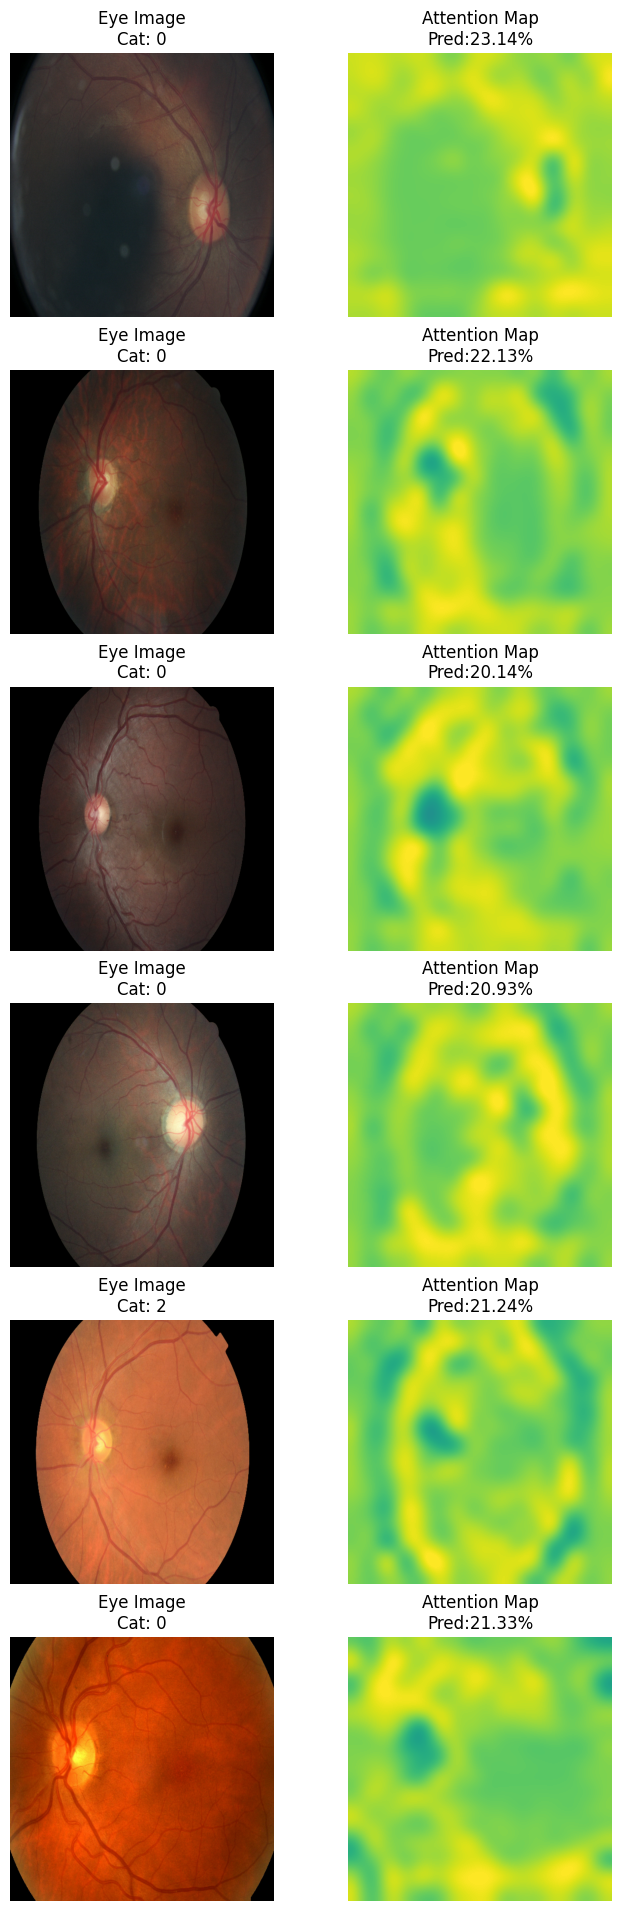

In [35]:
import tensorflow.compat.v1.keras.backend as K

rand_idx = np.random.choice(range(len(test_X)), size = 6)
attn_func = K.function(inputs = [retina_model.input, K.learning_phase()],
           outputs = [attn_layer.output]
          )

fig, m_axs = plt.subplots(len(rand_idx), 2, figsize = (8, 4*len(rand_idx)))
[c_ax.axis('off') for c_ax in m_axs.flatten()]
for c_idx, (img_ax, attn_ax) in zip(rand_idx, m_axs):
    cur_img = test_X[c_idx:(c_idx+1)]
    attn_img = attn_func([cur_img, 0])[0]
    img_ax.imshow(np.clip(cur_img[0,:,:,:]*127+127, 0, 255).astype(np.uint8))
    attn_ax.imshow(attn_img[0, :, :, 0]/attn_img[0, :, :, 0].max(), cmap = 'viridis',
                   vmin = 0, vmax = 1,
                   interpolation = 'lanczos')
    real_cat = np.argmax(test_Y[c_idx, :])
    img_ax.set_title('Eye Image\nCat:%2d' % (real_cat))
    pred_cat = retina_model.predict(cur_img)
    attn_ax.set_title('Attention Map\nPred:%2.2f%%' % (100*pred_cat[0,real_cat]))
fig.savefig('/content/drive/My Drive/keras/model/attention_map.png', dpi = 300)

In [36]:
from sklearn.metrics import accuracy_score, classification_report
pred_Y = retina_model.predict(test_X, batch_size = 16, verbose = True)
pred_Y_cat = np.argmax(pred_Y, -1)
test_Y_cat = np.argmax(test_Y, -1)
print('Accuracy on Test Data: %2.2f%%' % (accuracy_score(test_Y_cat, pred_Y_cat)))
print(classification_report(test_Y_cat, pred_Y_cat))

Accuracy on Test Data: 0.18%
              precision    recall  f1-score   support

           0       0.70      0.12      0.20      1151
           1       0.09      0.80      0.17       144
           2       0.21      0.19      0.20       244
           3       0.00      0.00      0.00        48
           4       0.00      0.00      0.00        43

    accuracy                           0.18      1630
   macro avg       0.20      0.22      0.11      1630
weighted avg       0.53      0.18      0.19      1630



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


<Axes: >

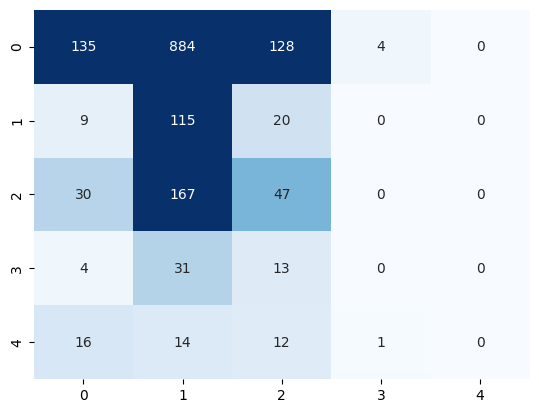

In [37]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
sns.heatmap(confusion_matrix(test_Y_cat, pred_Y_cat),
            annot=True, fmt="d", cbar = False, cmap = plt.cm.Blues, vmax = test_X.shape[0]//16)

### **6. Summary**

In the beginning, I feel that the comptiable issue in tenserflow 1.X and tenserflow 2.X in this HW6 example code, its a bit confusing. Initially when I process the image, it seems that there exists the image with zero bytes result in training termination.

Then when doing training, becasue of the RAM and memory limitation in Google Colab, I follow the original one epoch and I got the categorical_accuracy is 0.3147, the top_2_accuracy is 0.5307, whereas the val_categorical_accuracy is 0.1706 and the val_top_2_accuracy is 0.4435. I feel like the training result wasn't good enough, probably if i could have more RAM and memeory size, I would do more epoch to train the model.

# Part 2 A model directly computing the DR label without generating the attention

In a separate fork of the kernel, you will need to make a model directly computing the DR label without generating the attention. In the last paragraph, you report the accuracies of the models with and without attention and comment on the difference.

In this part, I will try to use VGG16 to compute the label instead of attention.

## 1. The VGG16 model

In [17]:
from keras.applications import VGG16
from sklearn.metrics import accuracy_score, classification_report
from tensorflow.keras.metrics import top_k_categorical_accuracy

In [19]:
# Define top-2 accuracy metric
def top_2_accuracy(y_true, y_pred):
    return top_k_categorical_accuracy(y_true, y_pred, k=2)

In [20]:
in_lay = Input(t_x.shape[1:])
vgg_model = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=t_x.shape[1:])
layer = vgg_model.output
layer = Flatten()(layer)
layer = Dense(512, activation='relu')(layer)
layer = Dropout(0.5)(layer)
layer = Dense(256, activation='relu')(layer)
layer = Dense(5, activation='softmax')(layer) # Softmax for multiclass
second_model = Model(inputs=vgg_model.input, outputs=layer)
second_model.compile(optimizer = 'adam', loss = 'categorical_crossentropy',metrics = ['categorical_accuracy',top_2_accuracy])
second_model.summary()

58889256/58889256 [==============================] - 4s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 512, 512, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 512, 512, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 512, 512, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 256, 256, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 256, 256, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 256, 256, 128)     147584    
                                                              

## 2. Train the VGG model

In [22]:
weight_path="/content/drive/My Drive/keras/model/{}_weights.best.hdf5".format('retina_Vgg16')

checkpoint = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1,
                             save_best_only=True, mode='min', save_weights_only = True)

reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss', factor=0.8, patience=3, verbose=1, mode='auto', min_delta=0.0001, cooldown=5, min_lr=0.0001)
early = EarlyStopping(monitor="val_loss",
                      mode="min",
                      patience=6) # probably needs to be more patient, but kaggle time is limited
from tensorflow.keras.callbacks import CSVLogger
csv_logger = CSVLogger('/content/drive/My Drive/keras/model/second_model_training_log.csv', append=False)

# List of callbacks including the CSVLogger
callbacks_list = [checkpoint, early, reduceLROnPlat, csv_logger]



In [23]:
second_model.fit_generator(train_gen,
                           steps_per_epoch = train_df.shape[0]//batch_size,
                           validation_data = valid_gen,
                           validation_steps = valid_df.shape[0]//batch_size,
                           epochs = 1,
                           callbacks = callbacks_list,
                           workers = 0, # tf-generators are not thread-safe
                           use_multiprocessing=False,
                           max_queue_size = 0
                           )

<ipython-input-23-e790f0a8deed>:1: UserWarning: `model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  second_model.fit_generator(train_gen,


75/75 [==============================] - ETA: 0s - batch: 37.0000 - size: 10.0000 - loss: 2.5539 - categorical_accuracy: 0.1947 - top_2_accuracy: 0.3973

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates



Epoch 1: val_loss improved from inf to 1.60323, saving model to /content/drive/My Drive/keras/model/retina_Vgg16_weights.best.hdf5
75/75 [==============================] - 483s 6s/step - batch: 37.0000 - size: 10.0000 - loss: 2.5539 - categorical_accuracy: 0.1947 - top_2_accuracy: 0.3973 - val_loss: 1.6032 - val_categorical_accuracy: 0.7036 - val_top_2_accuracy: 0.7309 - lr: 0.0010


In [21]:
second_model.load_weights('/content/drive/My Drive/keras/model/retina_Vgg16_weights.best.hdf5')
#second_model.save('/content/drive/My Drive/keras/model/VGG16_retina_model.h5')

In [29]:
pred_Y = second_model.predict(test_X[:100], batch_size = 16, verbose = True)
pred_Y_cat = np.argmax(pred_Y, -1)
test_Y_cat = np.argmax(test_Y[:100], -1)
print('Accuracy on Test Data: %2.2f%%' % (accuracy_score(test_Y_cat, pred_Y_cat)))
print(classification_report(test_Y_cat, pred_Y_cat))

Accuracy on Test Data: 0.72%
              precision    recall  f1-score   support

           0       0.72      1.00      0.84        72
           1       0.00      0.00      0.00         8
           2       0.00      0.00      0.00        14
           3       0.00      0.00      0.00         3
           4       0.00      0.00      0.00         3

    accuracy                           0.72       100
   macro avg       0.14      0.20      0.17       100
weighted avg       0.52      0.72      0.60       100



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


<Axes: >

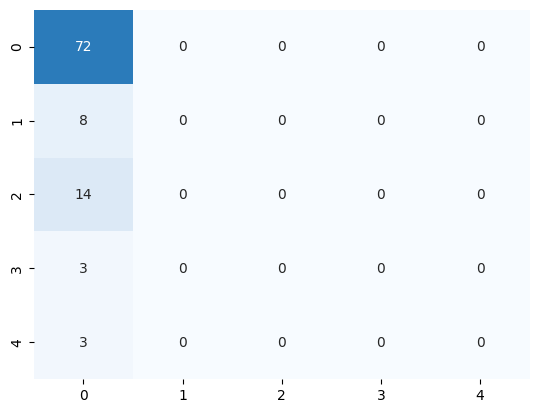

In [30]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
sns.heatmap(confusion_matrix(test_Y_cat, pred_Y_cat),
            annot=True, fmt="d", cbar = False, cmap = plt.cm.Blues, vmax = test_X.shape[0]//16)

### **6. Summary**

In order to compare with and without attention layer, both model use the same setting for training and testing.


The VGG16 model without attention layer has categorical_accuracy: 0.1947, top_2_accuracy: 0.3973, whereas in validation step, it has val_categorical_accuracy: 0.7036 and val_top_2_accuracy: 0.7309. Comparing to the model with attention layer, VGG16 model without attention layer obtained more loss compared to the model with attention layer(with attention layer loss:1.54, without attention layer: 2.55). While looking at the categorical_accuracy and the top_2_accuracy, though the VGG16 model without attention layer are lower in both metrics, regarding the val_categorical_accuracy and val_top_2_accuracy, the VGG16 model without attention layer are higher than the model with attention layer. Furthermore, when looking at the test result, we could find that the VGG16 model without attention layer (72%) yields a extremely better accuracy compared to the model with attention layer (18%).

To give conculsion only from these results, the attention model gives lower loss and also lower accuracy. But I don't feel this conclusion is strong enough because I only ran one epoch due to the memory size in Colab. Probably with more epochs, the training result would be different.





